In [1]:
# Python imports
import numpy as np # Matrix and vector computation package
import matplotlib.pyplot as plt  # Plotting library
# Allow matplotlib to plot inside this notebook
%matplotlib inline
# Set the seed of the numpy random number generator so that the tutorial is reproducable
np.random.seed(seed=1)
from sklearn import datasets, metrics # data and evaluation utils
from matplotlib.colors import colorConverter, ListedColormap # some plotting functions
import itertools
import collections
import math
import csv


In [2]:
def print_weights(filename, weights):
    with open(filename, "w") as f:
        writer = csv.writer(f)
        for w in weights:
            writer.writerows(w)

# Define the non-linear functions used
def logistic(z): 
    #return 1 / (1 + np.exp(-z))
    #return np.maximum(0, z)
    return z * (z > 0)

def logistic_deriv(y):  # Derivative of logistic function
    #return np.multiply(y, (1 - y))
    return 1. * (y > 0)
    
def softmax(z):
    return np.exp(z) / np.sum(np.exp(z), axis=1, keepdims=True)
    #return logistic(x)
    #e_x = np.exp(x - np.max(x))
    #a=  e_x / np.sum(e_x, axis=0, keepdims = True)
    #return a

In [3]:
# Define the layers used in this model
class Layer(object):
    """Base class for the different layers.
    Defines base methods and documentation of methods."""
    
    def get_layer_type(self):
        return ""
    
    def get_params_iter(self):
        """Return an iterator over the parameters (if any).
        The iterator has the same order as get_params_grad.
        The elements returned by the iterator are editable in-place."""
        return []
    
    def get_params_grad(self, X, output_grad):
        """Return a list of gradients over the parameters.
        The list has the same order as the get_params_iter iterator.
        X is the input.
        output_grad is the gradient at the output of this layer.
        """
        return []
    
    def get_output(self, X):
        """Perform the forward step linear transformation.
        X is the input."""
        pass
    
    def getW(self):
        return []
    
    def get_input_grad(self, Y, output_grad=None, T=None):
        """Return the gradient at the inputs of this layer.
        Y is the pre-computed output of this layer (not needed in this case).
        output_grad is the gradient at the output of this layer 
         (gradient at input of next layer).
        Output layer uses targets T to compute the gradient based on the 
         output error instead of output_grad"""
        pass

In [4]:
class LinearLayer(Layer):
    """The linear layer performs a linear transformation to its input."""
    
    def get_layer_type(self):
        return "linear"
    
    def __init__(self, n_in, n_out):
        """Initialize hidden layer parameters.
        n_in is the number of input variables.
        n_out is the number of output variables."""
        self.W = np.random.randn(n_in, n_out) *0.1
        self.b = np.zeros(n_out)

        #self.b = n_out * 0.5
        #self.W = np.random.randn(n_in, n_out).astype(np.float32) * np.sqrt(2.0/(n_in)) * 0.1
        #self.b = np.zeros([n_out]).astype(np.float32)  * 0.1
        #self.b = np.reshape(self.b,(n_out,1))
        
    def get_params_iter(self):
        """Return an iterator over the parameters."""
        return itertools.chain(np.nditer(self.W, op_flags=['readwrite']),
                               np.nditer(self.b, op_flags=['readwrite']))
    
    def get_output(self, X):
        """Perform the forward step linear transformation."""
        return X.dot(self.W) + self.b
        
    def get_params_grad(self, X, output_grad):
        """Return a list of gradients over the parameters."""
        JW = X.T.dot(output_grad)
        Jb = np.sum(output_grad, axis=0)
        np.set_printoptions(suppress=True)
        #print("JWshpe"+ str(JW.T.shape))
        #print("JW"+ str(JW.T))
        #print("JBshpe"+ str(Jb.T.shape))
        #print("JB"+ str(Jb.T))
        return [g for g in itertools.chain(np.nditer(JW), np.nditer(Jb))]
    
    def get_input_grad(self, Y, output_grad):
        """Return the gradient at the inputs of this layer."""
        return output_grad.dot(self.W.T)

In [5]:
class LogisticLayer(Layer):
    """The logistic layer applies the logistic function to its inputs."""
    
    def get_layer_type(self):
        return "activation"
    
    def get_output(self, X):
        """Perform the forward step transformation."""
        return logistic(X)
    
    def get_input_grad(self, Y, output_grad):
        """Return the gradient at the inputs of this layer."""
        return np.multiply(logistic_deriv(Y), output_grad)

In [6]:
class SoftmaxOutputLayer(Layer):
    """The softmax output layer computes the classification propabilities at the output."""
    
    def get_layer_type(self):
        return "activation"
    
    def get_output(self, X):
        """Perform the forward step transformation."""
        return softmax(X)
    
    def get_input_grad(self, Y, T):
        """Return the gradient at the inputs of this layer."""
        return (Y - T) / Y.shape[0]
    
    def get_cost(self, Y, T):
        """Return the cost at the output of this output layer."""
        return - np.multiply(T, np.ma.log(Y)).sum() / Y.shape[0]

In [7]:
def to_onehot_vec(data, shape):
    Y = np.zeros(shape=shape, dtype=int)
    Y[data, np.arange(data.size)] = 1
    return Y

In [8]:
X = np.loadtxt(fname = "Question2_123/x_train.csv", dtype=int, delimiter=',', unpack=True)
m = X.shape[1]

split = math.ceil(0.7 * m)

X_validate = X [:, split: ]
X = X [:, : split]

#X= [-1, 1, 1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, 1]
#X = np.reshape(X,  (14, 1))
data = np.loadtxt(fname = "Question2_123/y_train.csv", dtype=int, delimiter=',')
Y = to_onehot_vec(data, (4,m))

Y_validate = Y [:, split: ]
Y = Y [:, : split]

X_test= np.loadtxt(fname = "Question2_123/x_test.csv", dtype=int, delimiter=',', unpack=True)


data = np.loadtxt(fname = "Question2_123/y_test.csv", dtype=int, delimiter=',')
Y_test = to_onehot_vec(data, (4, X_test.shape[1]))
X= X.T
X_validate = X_validate.T
X_test = X_test.T
Y = Y.T
Y_validate = Y_validate.T
Y_test = Y_test.T

print(Y.shape)

# Create the minibatches
batch_size = 25
no_of_batches = m / batch_size
# Create batches (X,Y) from the training set
batches = zip(
    np.array_split(X, no_of_batches, axis=0),  # X samples
    np.array_split(Y, no_of_batches, axis=0))  # Y targets

biases = np.genfromtxt(fname = 'Question2_4/b/b-100-40-4.csv', delimiter=',')
b1 = biases[0][:100]
b2 = biases[1][:40]
b3 = biases[2][:4]
b1 = np.reshape(b1, (1, 100))
b2 = np.reshape(b2, (1, 40))
b3 = np.reshape(b3, (1, 4))

weights = np.genfromtxt(fname = 'Question2_4/b/w-100-40-4.csv', delimiter=',')
w1 = weights[:14,:100]
w2 = weights[14:114,:40]
w3 = weights[114:,:4]


w1 = np.reshape(w1, (100, 14))
w2 = np.reshape(w2, (40, 100))
w3 = np.reshape(w3, (4, 40))
ls_costs = []

(9175, 4)


In [9]:
# Define a sample model to be trained on the data
hidden_neurons_1 = 40  # Number of neurons in the first hidden-layer
hidden_neurons_2 = 100  # Number of neurons in the second hidden-layer
# Create the model
layers = [] # Define a list of layers
# Add first hidden layer
#layers.append(LinearLayer(w1,b1))
layers.append(LinearLayer(X.shape[1], hidden_neurons_1))
layers.append(LogisticLayer())
# Add second hidden layer
#layers.append(LinearLayer(w2,b2))
layers.append(LinearLayer(hidden_neurons_1, hidden_neurons_2))
layers.append(LogisticLayer())
# Add output layer
#layers.append(LinearLayer(w3,b3))
layers.append(LinearLayer(hidden_neurons_2, Y.shape[1]))
layers.append(SoftmaxOutputLayer())

In [10]:
# Define the forward propagation step as a method.
def forward_step(input_samples, layers):
    """
    Compute and return the forward activation of each layer in layers.
    Input:
        input_samples: A matrix of input samples (each row is an input vector)
        layers: A list of Layers
    Output:
        A list of activations where the activation at each index i+1 corresponds to
        the activation of layer i in layers. activations[0] contains the input samples.  
    """
    activations = [input_samples] # List of layer activations
    # Compute the forward activations for each layer starting from the first
    X = input_samples
    for layer in layers:
        Y = layer.get_output(X)  # Get the output of the current layer
        activations.append(Y)  # Store the output for future processing
        X = activations[-1]  # Set the current input as the activations of the previous layer
    return activations  # Return the activations of each layer

In [11]:
# Define the backward propagation step as a method
def backward_step(activations, targets, layers):
    """
    Perform the backpropagation step over all the layers and return the parameter gradients.
    Input:
        activations: A list of forward step activations where the activation at 
            each index i+1 corresponds to the activation of layer i in layers. 
            activations[0] contains the input samples. 
        targets: The output targets of the output layer.
        layers: A list of Layers corresponding that generated the outputs in activations.
    Output:
        A list of parameter gradients where the gradients at each index corresponds to
        the parameters gradients of the layer at the same index in layers. 
    """
    param_grads = collections.deque()  # List of parameter gradients for each layer
    output_grad = None  # The error gradient at the output of the current layer
    # Propagate the error backwards through all the layers.
    # Use reversed to iterate backwards over the list of layers.
    for layer in reversed(layers):   
        Y = activations.pop()  # Get the activations of the last layer on the stack
        # Compute the error at the output layer.
        # The output layer error is calculated different then hidden layer error.
        if output_grad is None:
            input_grad = layer.get_input_grad(Y, targets)
        else:  # output_grad is not None (layer is not output layer)
            input_grad = layer.get_input_grad(Y, output_grad)
        # Get the input of this layer (activations of the previous layer)
        X = activations[-1]
        # Compute the layer parameter gradients used to update the parameters
        grads = layer.get_params_grad(X, output_grad)
        param_grads.appendleft(grads)
        # Compute gradient at output of previous layer (input of current layer):
        output_grad = input_grad
    return list(param_grads)  # Return the parameter gradients

In [12]:
# Define a method to update the parameters
def update_params(layers, param_grads, learning_rate):
    """
    Function to update the parameters of the given layers with the given gradients
    by gradient descent with the given learning rate.
    """
    weights = [];
    for layer, layer_backprop_grads in zip(layers, param_grads):
        for param, grad in zip(layer.get_params_iter(), layer_backprop_grads):
            # The parameter returned by the iterator point to the memory space of
            #  the original layer and can thus be modified inplace.
            """"
            if(layer.get_layer_type() == "linear"):|
                reg = 0.002* np.sum(layer.W)/layer.W.shape[1]
                #print(np.sum(layer.W))
            else:
                reg = 0
            """
            param -= learning_rate * grad    # Update each parameter
        #if(layer.get_layer_type() == "linear"):
            #weights.append(layer.W)
            #print(layer.W)
    #print_weights("weights"+str(i)+".csv", weights);
    


In [13]:
# Perform backpropagation
# initalize some lists to store the cost for future analysis       
training_costs = []
testing_costs= []
minibatch_costs = []
validation_costs= []

max_nb_of_iterations = 700  # Train for a maximum of 300 iterations
learning_rate = 0.1  # Gradient descent learning rate

use_mini_batch = False

# Train for the maximum number of iterations
for iteration in range(max_nb_of_iterations):
    #print("iter: " + str(iteration))
    if not use_mini_batch:
        activations = forward_step(X, layers)  # Get the activations
        param_grads = backward_step(activations, Y, layers)  # Get the gradients        
        update_params(layers, param_grads, learning_rate)  # Update the parameters
    else: 
        for X_batch, Y_batch in batches:  # For each minibatch sub-iteration
            activations = forward_step(X_batch, layers)  # Get the activations
            minibatch_cost = layers[-1].get_cost(activations[-1], Y_batch)  # Get cost
            minibatch_costs.append(minibatch_cost)
            param_grads = backward_step(activations, Y_batch, layers)  # Get the gradients
            update_params(layers, param_grads, learning_rate)  # Update the parameters

    
    # Get full training cost for future analysis (plots)
    activations = forward_step(X, layers)
    train_cost = layers[-1].get_cost(activations[-1], Y)
    training_costs.append(train_cost)
    #print("training cost:" + str(train_cost))
    
    """
    # Get full testing cost for future analysis (plots)
    activations_test= forward_step(X_test, layers)
    test_cost = layers[-1].get_cost(activations_test[-1], Y_test)
    testing_costs.append(test_cost)
    """
    
    # Get full validation cost
    activations = forward_step(X_validate, layers)
    validation_cost = layers[-1].get_cost(activations[-1], Y_validate)
    validation_costs.append(validation_cost)

    if len(validation_costs) > 3:
        # Stop training if the cost on the validation set doesn't decrease
        #  for 3 iterations
        if validation_costs[-1] >= validation_costs[-2] >= validation_costs[-3]:
            print("not decresasing")
    
nb_of_iterations = iteration + 1  # The number of iterations that have been executed

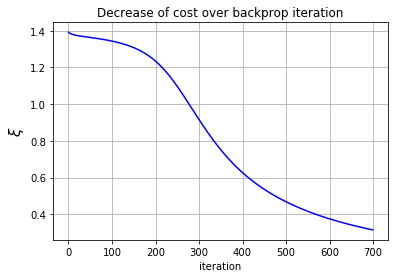

In [14]:
# Plot the cost over the iterations
if not use_mini_batch:
    plt.plot(training_costs, 'b-')
    plt.xlabel('iteration')
    plt.ylabel('$\\xi$', fontsize=15)
    plt.title('Decrease of cost over backprop iteration')
    plt.grid()
    plt.show()
else:
    minibatch_costs = np.array(minibatch_costs);
    minibatch_x_inds = np.linspace(0, nb_of_iterations, num=nb_of_iterations*no_of_batches)
    iteration_x_inds = np.linspace(1, nb_of_iterations, num=nb_of_iterations)
    
    # Plot the cost over the iterations
    #plt.plot(minibatch_x_inds, minibatch_costs, 'k-', linewidth=0.5, label='cost minibatches')
    plt.plot(iteration_x_inds, training_costs, 'r-', linewidth=2, label='cost full training set')
    plt.plot(iteration_x_inds, validation_costs, 'b-', linewidth=3, label='cost validation set')
    # Add labels to the plot
    
    #plt.plot(minibatch_costs, 'b-')
    
    plt.xlabel('iteration')
    plt.ylabel('$\\xi$', fontsize=15)
    plt.title('Decrease of cost over backprop iteration')
    plt.legend()
    x1,x2,y1,y2 = plt.axis()
    plt.axis((0,nb_of_iterations,0,2.5))
    plt.grid()
    plt.show()


In [15]:
X3= [-1, 1, 1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, 1]
X3= np.reshape(X3,  (1, 14))


activations1 = forward_step(X3, layers)
print(activations1.pop())

[[ 0.98682024  0.01317854  0.00000121  0.        ]]


In [16]:
# Get results of test data
y_true = np.argmax(Y_test, axis=1)  # Get the target outputs
activations = forward_step(X_test, layers)  # Get activation of test samples
y_pred = np.argmax(activations[-1], axis=1)  # Get the predictions made by the network
test_accuracy = metrics.accuracy_score(y_true, y_pred)  # Test set accuracy
print('The accuracy on the test set is {:.2f}'.format(test_accuracy))

[2 3 3 ..., 1 1 0]
[2 3 3 ..., 1 1 1]
The accuracy on the test set is 0.88
